In [1]:
import tensorflow as tf

print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available: 1


# Chapter 15 | Processing Sequences Using RNNs and CNNs
In this chapter we will focus on **Recurrent Neural Networks (RNNs)**, which is a class of nets able to analyze time series data, learning past patterns in order to use this knowledge to forecast the future, assuming of course that past patterns still hold in the future.

RNNs can work on sequences of **arbitrary lengths**, making them useful for **Natural Language Processing (NLP)** applications.

In this chapter we will go through the fundamental concepts about RNNs, how to train them using **backpropagation throught time** and how to use them to forecast a time series; we will then look at the popular **ARMA** family of models, comparing them with our RNNs; we woòò then explore the 2 main difficulties that RNNs face:
- **unstable gradients** (Chapter 11), which can be alleviated using techniques such as **recurrent dropout** and **layer normalization**;
- a very **limited short-term memory**, which can be extendes using **LSTM** and **GRU** cells.

Note that RNNs are not the only NN capable of handling sequential data: regular dense networks can manage small sequences, while convolutional neural networks can handle even very long sequences.

## Recurrent Neurons and Layers
A **Recurrent Neural Network** looks very much like a **Feedforward Neural Network**, except it also has **connections pointing backwards**.

The simplest possible RNN is composed of one neuron receiving inputs, producing an output and sending it back to itself.

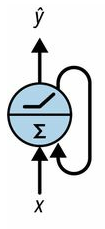

At each **time step t** (also called **frame**), this recurrent neuron receives the inputs $x_{(t)}$ as well as its own output from the previous time step $\hat{y}_{(t-1)}$ (at the first time step, this is generally set to 0).

We can then represent a tiny network composed of a single neuron **against the time axis** (this process is also called **unrolling the network through time**):

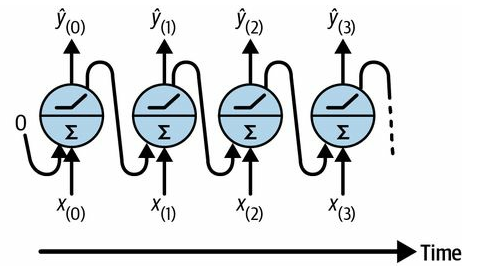

Of course we can easily create a **layer of recurrent neurons**, in which at each time step $t$, every neuron receives both the input vector $x_{(t)}$ and the output vector from the previous time step $\hat{y}_{(t-1)}$ (note how with 1 neuron, both inputs and outputs were a scalar, while with a full layer they are vectors).

Layer of recurrent neurons:

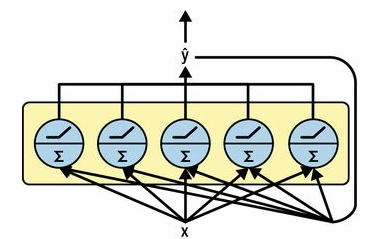

The same layer, but unrolled through time:

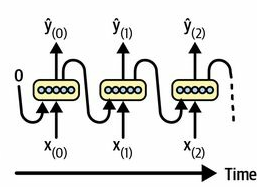

In this layer, each recurrent network has **2 sets of weights**:
- the vector $w_x$ for the inputs $x_{(t)}$;
- the vector $w_{\hat y}$, for the previous time step outputs $\hat y_{(t-1)}$.

If we consider the weights of the whole recurrent layer, we have **2 weight matrices**:
- $W_x$;
- $W_{\hat y}$.

The **output vector** of the whole recurrent layer is then easily computed as:
$$ \hat y_{(t)} = \phi (W_x^T x_{(t)} + W_{\hat y}^T \hat y_{(t-1)} + b)$$
(with activation function $\phi$ and bias $b$)

Just as with Feedforward Neural Network, we can compute a recurrent layer's output in one shot for an entire mini-batch by placing all the inputs at time step $t$ into an inpuy matrix $X_{(t)}$:

$$\hat Y_{(t)} = \phi (X_{(t)}W_x + \hat Y_{(t-1)} W_{\hat y} + b) = \phi([X_{(t)} \hat Y_{(t-1)}] W + b)$$
where:
- $Y_{(t)}$ is an $m \times n_{neurons}$ matrix containing the layer's outputs at time step $t$ for each instance in the mini-batch ($m$ is the number of instances in the mini-batch, $n_{neurons}$ is the number of neurons);
- $X_{(t)}$ is an $m \times n_{inputs}$ matrix containing the inputs for all instances ($n_{inputs}$ is the number of input features);
- $W_x$ is an $n_{inputs} \times n_{neurons}$ matrix containing the connection weights for the inputs of the current time step;
- $W_{\hat y}$ is an $n_{neurons} \times n_{neurons}$ matrix containing the connection weights for the outputs of the previous time step;
- $b$ is a vector of size $n_{neurons}$ containing each neuron's bias term;
- $[X_{(t)}\hat Y_{(t-1)}]$ is the horizontal concatenation of the matrices $X_{(t)}$ and $\hat Y_{t-1}$;
- $W$ is an $(n_{inputs} + n_{neurons}) \times n_{neurons}$ matrix which is the vertical concatenation of the weight matrices $W_x$ and $W_{\hat y}$.

Notice how $\hat Y_{(t)}$ is a function of $X_{(t)}$ and $\hat Y_{(t-1)}$, and that $\hat Y_{(t-1)}$ is a function of $X_{(t-1)}$ and $\hat Y_{(t-2)}$, and so on. 

This makes $\hat Y_{(t)}$ a function of all the inputs since time $t = 0$, that is $X_{(0)}, X_{(1)}, ...,X_{(t)}$.

### Memory Cell
This previous characteristic of the output of a recurrent network at time step $t$ being function of all the inputs from previos time steps works like a form of **memory**: a part of a neural network that **preserves some state across time steps** is called a **Memory Cell** (or just **Cell**).

A single recurrent neuron or recurrent layer is a very basic cell, capable of learning short patterns (typically about 10 steps long, but depends on the task), so we'll see more complex and powerful types of cells capable of learning longer patterns (roughly 10 times longer, but depends on the task).

We denote with $h_{(t)}$ the **cell's state at time step t** ("h" stands for "hidden"); being it a function of some inputs at that time step and its state at the previous time steps we write:
$$ h_{(t)} = f(x_{(t)}, h_{(t-1)})$$ 
(in case of basic cells like the ones we have discussed so far, the output at time step $t$ ($\hat y_{(t)}$) is equal to the state, but in more complex cells this is not always the case)

### Input and Output Sequences
We have 4 main types of RNNs network based on the "timing" it gets input and produces outputs:

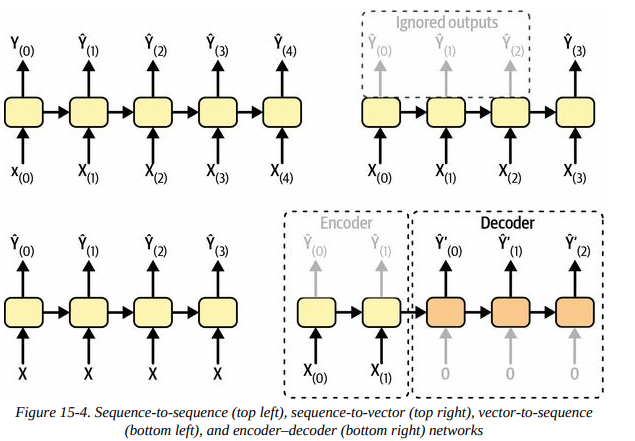

- **sequence-to-sequence network** (top-left): it can simultaneously take a sequence of inputs and produce a sequence of outputs (e.g., takes the daily power consumption over the last N days and outputs the daily power consumption shifted by one day into the future, so from N-1 days ago to tomorrow);
- **sequence-to-vector network** (top-right): it takes a sequence of inputs and can ignore all outputs except the last one (e.g., takes a sequence of words corresponding to a movie review and outputs a sentiment score from 0 (hate) to 1 (love));
- **vector-to-sequence network** (bottom-left): it takes the same input vector over and over at each time step and outputs a sequence (e.g., takes an image, or a CNN output, and outputs a caption of that image);
- **sequence-to-vector network** (or **encoder**) followed by a **vector-to-sequence network** (or **decoder**) (bottom-right): it takes an input, encodes it in a vector representation and then decode it (e.g., takes a sentence in one language, encoder converts it into a vector representation and decoder decodes this vector into a sentence in another language); we will see this **encoder-decoder RNN** in Chapter 16. 

## Training RNNs
The idea is to **unroll it through time** and then use **regular backpropagation** and that's why this strategy is called **Backpropagation Through Time (BPTT)**.

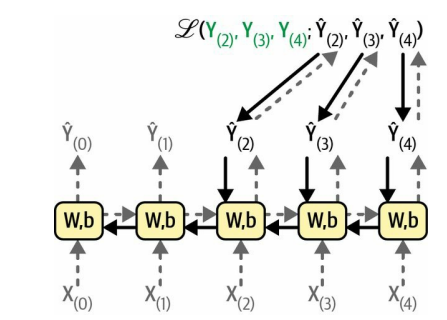

Just like in regular backpropagation, there's a first forward pass throught the unrolled network (dasged arrows) and then the output sequence is **evaluated** using a **loss function**: 
$$L(Y_{(0)}, Y_{(1)}, ..., Y_{(T)}; \hat Y_{(0)}, \hat Y_{(0)}, \hat Y_{(1)}, ...., \hat Y_{(T)})$$
where:
- $Y_{(i)}$ is the $i^{th}$ target;
- $\hat Y_{(i)}$ is the $i^{th}$ prediction;
- $T$ is the max time step.

Note that this loss function **may ignore some outputs** (for example in the image above just the last 3 outputs are used to compute it). The **gradients** of that loss function are then **propagated backward** (solid arrows). in this example, since first 2 outputs are not used to compute the loss, the gradients do not flow backwards through them. Moreover, since the same parameters $W$ and $b$ are used at each time step, the gradients will be tweaked multiple times furing backpropagation. Once all the gradients have been computed, a **gradient descent step** is performed to update the parameters.


## Forecasting a Time Series
We will start analyizing time series with classical tools, to better understand what we're dealing with.

We will pretend to work for Chicago's Transit Authority, so we must build a model capable of forecasting the number of passengers that will ride on bus and rail the next day. We have access to daily ridership data since 2001.

Let's start by load and clean the [data](https://data.cityofchicago.org/Transportation/CTA-Ridership-Daily-Boarding-Totals/6iiy-9s97/about_data):

In [4]:
import pandas as pd
from pathlib import Path

path = Path('/mnt/c/Users/39388/OneDrive/Data Science/projects/handsonML/15_RNNs_and_CNNs/CTA_-_Ridership_-_Daily_Boarding_Totals_20250801.csv')
df = pd.read_csv(path, parse_dates = ['service_date'])
df.columns = ['date', 'day_type', 'bus', 'rail', 'total'] #shorter names
df = df.sort_values('date').set_index('date')
df = df.drop('total', axis = 1) #total is just bus + rail so it's useless
df = df.drop_duplicates()

We look at the first rows:

In [5]:
df.head()

,day_type,bus,rail
date,,,
2001-01-01,U,297192,126455
2001-01-02,W,780827,501952
2001-01-03,W,824923,536432
2001-01-04,W,870021,550011
2001-01-05,W,890426,557917


(NOTE: day_type contains W for **W**eekdays, A for S**a**turdays and U for S**u**ndays)

Let's now plot bus and rail riderships over a few months in 2019, more precisely from 1st of March 2019 to 31st of May 2019:

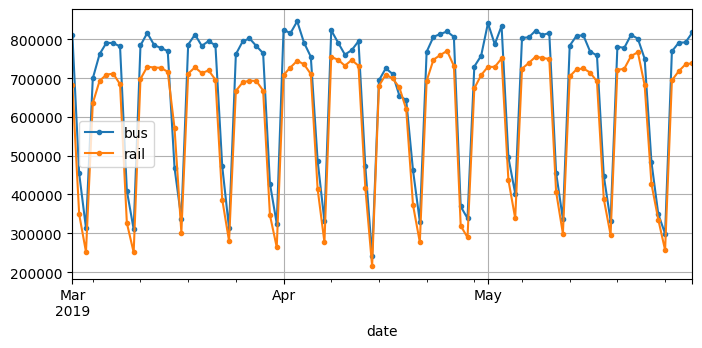

In [6]:
import matplotlib.pyplot as plt

df['2019-03':'2019-05'].plot(grid = True, marker = '.', figsize = (8, 3.5))
plt.show()

What we see above is a **time series**: data with values at different time steps, usually at regular intervals; more precisely, this is a **multivariate time series**, because we have multiple values per time step (both bus and rail number of passengers).

The most typical task with time series is **Time Series Forecasting** (i.e., predicting future values), which is what we'll try to do now, but there are others, like **Imputation** (i.e., filling in missing past values), **Classification**, **Anomaly Detection** and more.

By looking at the figure above, there's a strong pattern repeated every week: this is called **weekly seasonality**; it is so strong that we could forecast tomorrow's ridership by copying the values from the previous week and get good results: this technique is called **Naive Forecasting**, which is often a great baseline and sometimes even difficult to beat.

(NOTE: generally Naive Forecasting implies copying the last known value, so we should forecast tomorrow with today's value, but in our case, due to weekly seasonality, this approach works better)

Let's visualize Naive Forecasting by overlaying the original time series and the same time series lagged by one week (i.e., shifted toward the right by one week). We'll also plot the difference between the 2, which is an approach called **differencing**:

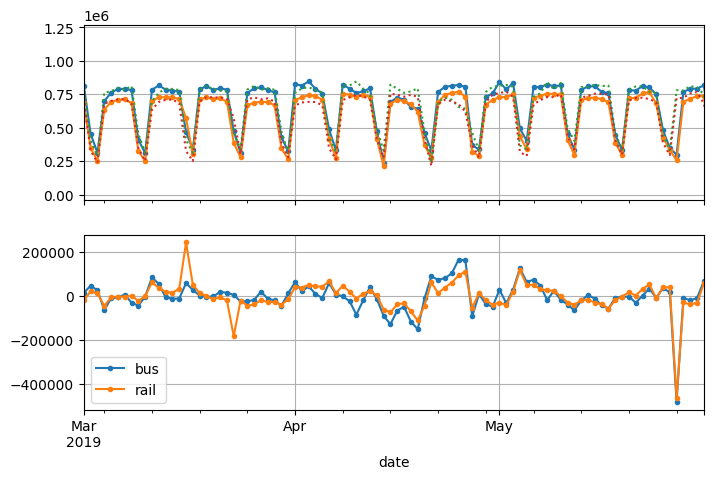

In [8]:
diff_7 = df[['bus', 'rail']].diff(7)['2019-03':'2019-05']

fig, axs = plt.subplots(2, 1, sharex = True, figsize = (8, 5))
df.plot(ax = axs[0], legend = False, marker = '.') #original time series
df.shift(7).plot(ax = axs[0], grid = True, legend = False, linestyle = ':') #lagged time series
diff_7.plot(ax = axs[1], grid = True, marker = '.') #7-day difference time series
plt.show()

The figure above shows us that Naive Forecasting would perform quite good. When a time series is correlated with a lagged version of itself we say that time series is **autocorrelated**.

We see huge difference at the end of May, so we may think there was a holiday at that time. Let's check the day_type column at the end of May:

In [9]:
df.loc['2019-05-25':'2019-05-27']['day_type']

date
2019-05-25    A
2019-05-26    U
2019-05-27    U
Name: day_type, dtype: object

Indeed, there was a long weekend back then (Monday was the Memorial Day holiday); we could use this to improve our forecasts, but for now we'll evaluate the model like this.

For time series, the 3 most used metrics are:
- **MAE (Mean Absolute Error)**;
- **MAPE (Mean Absolute Percentage Error)**;
- **MSE (Mean Squared Error)** which is preferred when we want to strongly penalize large errors.

Let's measure the Mean Absolute Error over the three-month period we were focussing on:

In [10]:
diff_7.abs().mean()

bus     43915.608696
rail    42143.271739
dtype: float64

Our Naive Forecasts get a MAE of about 43916 bus riders and about 42143 rail riders. 

Let's divide these by the target values to get the MAPE and have a better idea of the proportion of the errors:

In [12]:
targets = df[['bus', 'rail']]['2019-03':'2019-05']
(diff_7/targets).abs().mean()

bus     0.082938
rail    0.089948
dtype: float64

Our Naive Forecast got a MAPE of roughly 8.3% for bus and 9.0% for rail.

(NOTE: we got a better MAE with rail than with bus, while we got a better MAPE with bus than with rail; that's because even if MAE is larger in bus than in rail, when put into perspective it turns out the bus forecasts are slightly better than the rail's ones)

(to continue...)

### ARMA model family
(...)

### Preparing Time Series Datasets for ML
(...)

###  a Linear Model
(...)

### Forecasting using a Simple RNN
Let's implement the most basic RNN, containing a single recurrent layer with just one recurrent neuron (this is a **sequence-to-vector** model):

In [3]:
model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(1, input_shape = [None, 1])
])

All recurrent layers in Keras expect 3D inputs of shape **\[batch size, time steps, dimensionality]**, where dimensionality is 1 for univariate time series and more for multivariate ones. 

In our code, input_shape ignores the first dimension (i.e., the batch size), deals with input sequences of any lenght (second dimension is None) and since we are in a univariate time deries, dimensionality is 1.

Training and evaluating this model takes to a MAE greater than 100k (model is very bad), but we expected this because:
- with only 1 single recurrent neuron the RNN's memory is extremely limited;
- time series contains values from 0 to around 1.4, so using the default activation function tanh allows for outputs to be between -1 and 1.

Let's deal with these issues by enlarging the network (layer will contain 32 recurrent neurons) and by adding a sense output layer on top of it with a single output neuron and no activation function:

In [4]:
univar_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape = [None, 1]),
    tf.keras.layers.Dense(1)
])

/home/essskevin/tf-env/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Training and evaluating this model takes to a MAE around 27703, so the best model we have trained so far.

(NOTE: note how to reach best performance we should try to make time series more stationary, for example using differencing)

### Forecasing using a Deep RNN
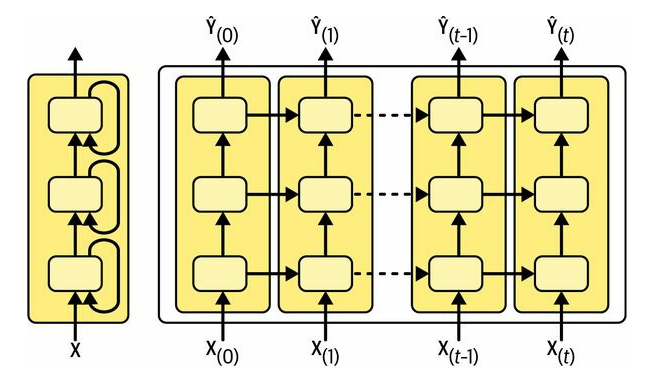

We will simply stack recurrent layers: 
- 2 **sequence-to-sequence** layer;
- 1 **sequence-to-vector** layer; 
- 1 Dense layer producing the model's forecast.

The model we obtain is very similar to the image above, but outputs from $\hat Y_{(0)}$ to $\hat Y_{(t-1)}$ are ignored and there's a dense layer on top of $\hat Y_{(t)}$:

In [5]:
deep_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, return_sequences=True, input_shape = [None, 1]),
    tf.keras.layers.SimpleRNN(32, return_sequences=True),
    tf.keras.layers.SimpleRNN(32),
    tf.keras.layers.Dense(1)
])

/home/essskevin/tf-env/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


(NOTE: return_sequences=True in all layers except last is needed to obtain a 3D output containing outputs for all time steps; not setting it to true returns a 2D output containing only the last time step output, so the next layer won't be fed with the right input)

This Deep RNN gets a MAE of about 31211, so it doesn't beat hour "shallower" RNN: it seems that this RNN is too large for our task.

### Forecasting Multivariate Time Series
(...)

### Forecasting Several Time Steps Ahead
(...)

### Forecasting uing a Sequence-to-Sequence Model
(...)

## Handling Long Sequences
To train a RNN on **long sequences**, makes the unrolled RNN a very deep network, taking it to suffer from the **unstable gradients problem** we discussed (Chapter 11), which means it may take forever to train, or training may be unstable. Moreover, the RNN will gradually forget the first inputs in the sequence.

Let's look at both these problems:

### Fighting the Unstable Gradients Problem
Many of the tricks used for Deep nets can also be used for RNNs: good parameter initialization, faster optimizers, dropout, and so on.

Nonsaturating activation functions (e.g., ReLU) may not work here, cause they may take to even more unstable RNNs during training: suppose a gradient descent updates the weights in a way that increases outputs slightly at first time step; considering the same weights are used at every time step, this would slightly increase outputs of all the next steps, until the outputs explode. A nonsaturating activation function does not prevent that. We could reduce this risk using a smaller learning rate or using a saturating activation function (like the hyperbolic tangent, which is indeed the default one).

In similar way, the gradients themselves can explode, so it is a good idea to monitor them (e.g., by using TensorBoard) and using **gradient clipping**.

Batch Normalization can't be used efficiently with RNNs: using it within recurrent layers (i.e., horizontally) doesn't yield good results, cause the BN layer will be used at each time step, with same parameters regardless of actual scale and offset of inputs; using it between recurrent layers (i.e., vertically) usually doesn't help that much and slows down training.

Another form of normalization with often works better with RNNs is **layer normalization**, introduce in 2016 by Jimmy Lei Ba in a [paper](https://arxiv.org/abs/1607.06450): it is very similar to batch normalization, but instead of normalizing across the batch dimension, it normalizes across the features dimension; it can compute required statistic on the fly, at each time step, for each instance, so its behaves the same way during training and testing (BN does not that), it doesn't need to use exponential moving averages. In a RNN, it is typically ysed after the linear combination of the inputs and the hidden states; let's implement one of them within a simple memory cell: we will need to define a custom memory cell that in its call() method takes the inputs at the current time step and the hidden states from the previous time step:

In [6]:
class LNSimpleRNNCell(tf.keras.layers.Layer):
    def __init__(self, units, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.state_size = units
        self.output_size = units
        self.simple_rnn_cell = tf.keras.layers.SimpleRNNCell(units, activation=None)
        self.layer_norm = tf.keras.layers.LayerNormalization()
        self.activation = tf.keras.activations.get(activation)
        
def call(self, inputs, states):
    outputs, new_states = self.simple_rnn_cell(inputs, states)
    norm_outputs = self.activation(self.layer_norm(outputs))
    return norm_outputs, [norm_outputs]

- LNSimpleRNNCell class inherits from the tf.keras.layers.Layer class, just like any custom layer;
- constructor takes number of units and desired activation function and sets the state_size and output_size attributes; then creates a SimpleRNNCell with no activation function (we want the layer normalization to be performed before it) and a LayerNormalization layer; then it fetches the desired activation function;
- the call() method applies the simpleRNNCell (computing the linear combination of current inputs and previous hidden states) returning the result twice (in a SimpleRNNCell, outputs are equal to hidden state, so we can safely ignore new_states); then it applies the layer normalization, then the activation function; it finally returns output twice again.

We now need to create a tf.keras.layers.RNN layer to use this custom cell:

In [8]:
custom_ln_model = tf.keras.Sequential([
    tf.keras.layers.RNN(LNSimpleRNNCell(32), return_sequences=True, input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
])

/home/essskevin/tf-env/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/home/essskevin/tf-env/lib/python3.12/site-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'ln_simple_rnn_cell', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


We can also implement dropout, considering most recurrent layers in Keras have dropout and recurrent_dropout hyperparameters:
- dropout | defines the dropout rate to apply to the inputs;
- recurrent_dropout | defines the dropout rate for the hidden states.

### Tackling the Short-Term Memory Problem
As we said, the more the RNN is trained on long sequences, the more it happens it has no trace of the first inputs; there are various type of cells with long-term memory which have been introduced and considering the have proven so successful, they replaced the basic cells in almost all tasks:

#### LSTM cells
The **LSTM (Long Short-Term Memory)** cell, introduced by Sepp Hochreiter and Jurgern Schmidhuber in 1997 [papers](https://scholar.google.com/scholar?q=Long+Short-Term+Memory+author%3ASchmidhuber), is the most popular of these long-term memory cells. Over the yars, was improved by several researchers, such as Alex Graves, Hasim Sak and Wojciech Zaremba.

The architecture of an LSTM cell is something like this:

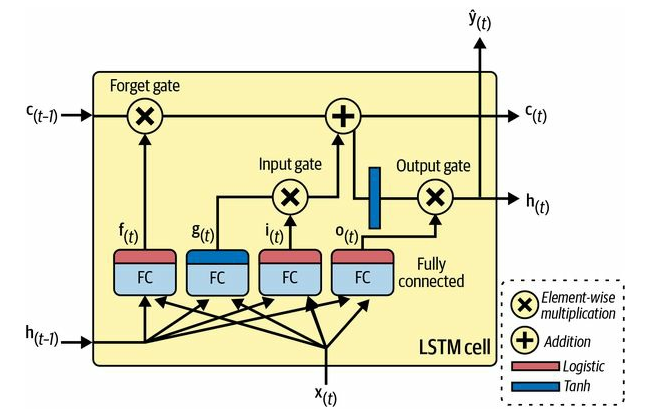

It is very similar to a regular cell, but it splits its state into 2 vectors:
- $h_{(t)}$, which we can think of as the **short-term state**;
- $c_{(t)}$, which we can think of as the **long-term state**.

When travsersing the network, the **long-term state** $c_{(t-1)}$ goes through a **forget gate**, dropping some memories; then it goes through an **addition operation**, which adds the memories selected by the **input gate**; the result $c_{(t)}$ is then sent out (so at each time step, some memories are dropped, some are added).

Moreover, after the addition operation, the long-term state is **copied** and passed through a tanh function; the result is then filtered by the **output gate**, producing the **short-term state** $h_{(t)}$ (which is equal to the cell's output for this time step $y_{(t)}$)

But, how do the gates work?

First, the current input vector $x_{(t)}$ and the previous short-term state $h_{(t-1)}$ are fed to four different fully connected layers, each serving different purposes:
- the main layer is the one that outputs $g_{(t)}$ from $x_{(t)}$ and $h_{(t-1)}$ (in a regular cell, there's only this layer);
- the other 3 layers are **gate controllers**: they usually use logistic activation function, creating outputs from 0 to 1, where 0 means to **close the gate**, 1 to **open it**; more specifically:
  - **forget gate** (controlled by $f_{(t)}$) controls the part of long-term state **to erase**;
  - **input gate** (controlled by $i_{(t)}$) controls the part of $g_{(t)}$ **to add** to the long-term state;
  - **output gate** (controlled by $o_{(t)}$) controls the part of long-term state **to be read and output** at this time step, which are $h_{(t)}$ and $y_{(t)}$.

To sum up, an LSTM cell learn to recognize important input (thanks to the input gate), store it in the long-term state preserving it for long as needed (thanks to the forget gate) and extract it whenever it is needed.

The **equations** of this LSTM cell are:

Input Gate:
$$i_{(t)} = \sigma(W_{xi}^T x_{(t)} + W_{hi}^T h_{(t-1)} + b_i )$$
Forget Gate:
$$f_{(t)} = \sigma(W_{xf}^T x_{(t)} + W_{hf}^T h_{(t-1)} + b_f )$$
Output Gate:
$$o_{(t)} = \sigma(W_{xo}^T x_{(t)} + W_{ho}^T h_{(t-1)} + b_o )$$
Candidate Cell State:
$$g_{(t)} = tanh(W_{xg}^T x_{(t)} + W_{hg}^T h_{(t-1)} + b_g )$$
Cell State Update:
$$c_{(t)} = f_{(t)} \cdot c_{(t-1)} + i_{(t)} \cdot g_{(t)}$$
Hidden State (and Output):
$$h_{(t)} = y_{(t)} = o_{(t)} \cdot tanh(c_{(t)})$$

where:
- $W_{xi}, W_{xf}, W_{xo}, W_{xg}$ are the **weight matrices** of each of the 4 layers **for their connection to the input vector** $x_{(t)}$;
- $W_{hi}, W_{hf}, W_{ho}, W_{hg}$ are the **weight matrices** of each of the 4 layers **for their connection to the previous short-term state** $h_{(t-1)}$;
- $b_i, b_f, b_o, b_g$ are the **bias terms** for each of the 4 layers (note, TF initializes $b_f$ to a vector full of 1s instead of 0s to prevent forget everything at the beginning of training)

In Keras, we can simply use the LSTM layer instead of the Simple RNN layer:

In [9]:
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True, input_shape = [None, 5]),
    tf.keras.layers.Dense(14)
])

/home/essskevin/tf-env/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


(NOTE: we can also use the general-purpose tf.keras.layers.RNN layer and giving LSTMCell as an argument, but the one we implemented above uses an optimized implementation when running on a GPU)

#### GRU cells
The **GRU (Gated Recurrent Unit)** cell, proposed by Kyunghyun Cho in a 2014 [paper](https://arxiv.org/abs/1406.1078), is a **popular variant of the LSTM** cell.

The architecture of a GRU cell is something like this:

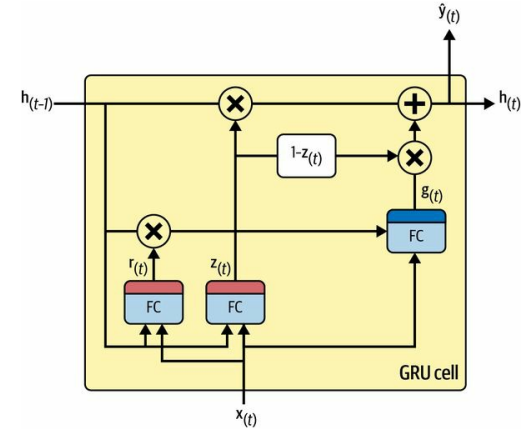

It appears as a simplified version of the LSTM cell, performing quite as well; the main simplifcations are:
- $h_{(t)}$ is no more split into the 2 state vectors;
- **single gate controller** $z_{(t)}$, which controls both the **forget gate** and the **input gate**: if the gate controller's outputs is 1, forget gate is open and the input gate is closed; if it is 0, the opposite happens; basically if a memory must be stored, the location where it will be stored is erased first;
- **no output gate**, cause the full state vector is the output at each time step; however there's a **new gate controller** $r_{(t)}$, which controls which part of the previous state will be shown to the main layer $g_{(t)}$.

The **equations** of the GRU cell are:
Update Gate:
$$z_{(t)} = \sigma(W_{xz}^T x_{(t)} + W_{hz}^T h_{(t-1)} + b_z )$$
Reset Gate:
$$r_{(t)} = \sigma(W_{xr}^T x_{(t)} + W_{hr}^T h_{(t-1)} + b_r )$$
Candidate Cell State:
$$g_{(t)} = tanh(W_{xg}^T x_{(t)} + W_{hg}^T(r_{(t)} \cdot h_{(t-1)}) + b_g )$$
Hidden State:
$$h_{(t)} = z_{(t)} \cdot h_{(t-1)} + (1- z_{(t)}) \cdot g_{(t)}$$

In Keras, we can simply use tf.keras.layers.GRU layer instead of the SimpleRNN or the LSTM layer; there's also tf.keras.layers.GRUCell to create a custom cell based on a GRU one.

LSTM and GRU are the main reasons behind the success of RNNs; even if they can tackle much longer sequences than simple RNNs, they still have a hard time learning sequences of 100 time steps or more; one way to solve this is to shorten the input sequences, for example by using **1D Convolutional Layers**.

#### Using 1D Convolutional Layers to Process Sequences
While a 2D Convolutional Layer (Chapter 14) works by sliding several fairly small kernels across an image, producing multiple 2D feature maps (one per kernel), using a **1D Convolutional Layer** similarly slides several kernels across a sequences, producing a 1D feature map per kernel. Each kernel will learn to detect a **single very short sequential pattern** (no longer than the kernel size).

(Continue...)


#### WaveNet
Introduced in a 2016 [paper](https://arxiv.org/abs/1609.03499) by Aaron van den Oord and other DeepMind researchers.

WaveNet stacked a 1D convolutional layer, doubling the **dilation rate** (i.e., how spread apart each neuron's inputs are) at every layer: first convolutional layer gets 2 time steps at a time, the next one 4, next one 8, and so on. In this way, lower layers learn short-term patterns, while higher layers learn long-term patterns.

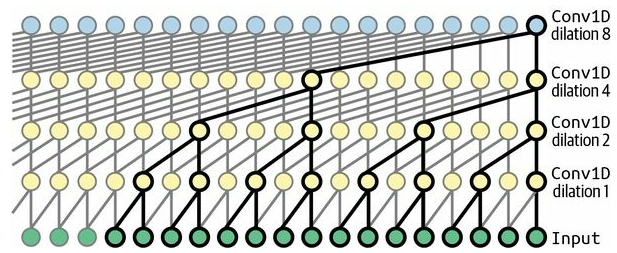

In the original WaveNet, they stacked 10 convolutional layers with dilation rates of 1, 2, 4, 8, ..., 256, 512; then, another grouped of 10 identical layers were stacked (with same dilation rates); then, another identical group of 10 layers. A single stack of these 10 convolutional layers, with these dilation rates, acts like a convolutional layer with kernel size of 1024, but way faster, more powerful and with way less parameters.

They also **left-padded** the input sequence, with a number of 0s equal to the dilation rate before every layer, to preserve the same sequence length throughout the network.

WaveNet achieved state-of-the-art performances on varios audio tasks, including text-to-speech tasks, such as reproducing realistic voices in several languages or generate music.

We can implement a simplified WaveNet for the same sequence:

In [10]:
wavenet_model = tf.keras.Sequential()
wavenet_model.add(tf.keras.layers.Input(shape=[None, 5]))
for rate in (1, 2, 4, 8) * 2:
    wavenet_model.add(tf.keras.layers.Conv1D(
        filters=32, kernel_size=2, padding="causal", activation="relu", dilation_rate=rate))
wavenet_model.add(tf.keras.layers.Conv1D(filters=14, kernel_size=1))

This has:
- Input Layer (it is simpler than setting input_shape on the first layer);
- 1D Convolutional Layer with "casual" padding (it is the same as "valid", but 0s are appendend only at the strat of the input sequence, instead on both sides); this ensure convolutiona layer does not peek into the future when making predictions;
- Similar Pairs of Layers with growing dilation rates (1, 2, 4, 8);
- Output Layer (a Convolutional Layer with 14 filters of size 1 without Activation Function); as we already saw in Chapter 14, this is equivalent to a Dense Layer with 14 units.

We don't need to crop or downsample the input sequence, cause thanks to casual padding every convolutional layer outputs a sequence of same length as the input.